# Classifier selection
Training data should be all set, let's take a quick look for sanity and then dig into building the text classifier. Plan here is to try a bunch of different things, follow any interesting ideas or insights and see what sticks. Some thoughts to get started:

1. ~~Should we use the DMLC XGBoost package or the gradient boosting classifier included in scikit-learn?~~ Use XGBoost via the scikit-learn API, classification performance is similar to scikit-learn's gradient boosting classifier, but it's much faster.

2. ~~Binary cross entropy seems like the obvious loss function to use, but what metrics should we track?~~

    - The default for XGBoost on this type of task is '**binary:logistic**' - but I haven't found exactly what that loss function is yet...
    - For scikit-learn gradient boosting classifier the default is '**log_loss**' which, according to the documentation 'refers to binomial and multinomial deviance, the same as used in logistic regression'.

    Ok, fine - only way I see to confirm that those are the same is dig into the source code. Definitely not worth the effort. At the end of the day, exactly what/how it is optimized and if it's the same between the two frameworks does not really matter - what we need is a way to evaluate both of them.

    I like false positive and false negative rates, we can get those from the confusion matrix (and also plot that at the same time). We should probably include accuracy as a percent for the less-statistically minded. We need a third to give a good look at the underlying probabilities rather than the 'calls'. Let's go with binary cross-entropy, in scikit-learn the **log_loss**.
    
3. ~~Do some hyperparameter tuning.~~ Done.
4. ~~Make sure we can do k-fold cross validation rather than looking at the test data all the time.~~ Done.
5. ~~Is there an easy way to do early stopping?~~ Yep - it's built into the sklearn API.
6. Is there an easy way to make training plots (i.e. training & validation loss over time)?
7. What about random forest?
8. Take a look at examples we have a hard time with.
9. ~~Take a look at feature importance.~~
10. Maybe throw in some other methods (i.e. deep neural network/logistic regression), just for completeness.
11. ~~Build a results data structure so we can track the winners at each stage.~~ Done.

## 1. Run set-up

In [1]:
# Change working directory to parent so we can import as we would from __main__.py
print(f'Working directory: ', end = '')
%cd ..

import pandas as pd
from functools import partial
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_validate
from hyperopt.pyll.base import scope
from hyperopt import fmin, tpe, hp, Trials

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs

Working directory: /mnt/arkk/llm_detector/classifier


In [2]:
# The dataset - omit the file extension, it will be
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
working_hdf5_file = f'{config.DATA_PATH}/{dataset_name}_stage_I.h5'

Let's also make a data structure to collect results for plotting as we go.

In [3]:
# Dictionary to hold testing/experimentation results
results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

## 2. Load and prepare data

In [4]:
# Open a connection to the hdf5 dataset via PyTables with Pandas so we can
# load the data from each bin as a dataframe
data_lake = pd.HDFStore(working_hdf5_file)

# Load bin data
data_df = data_lake[f'master']

# Close hdf5 connection
data_lake.close()

data_df.info()
data_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 55774 entries, 0 to 55773
Data columns (total 22 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   Fragment ID                                                             55774 non-null  int64  
 1   Source record num                                                       55774 non-null  int64  
 2   Fragment length (words)                                                 55774 non-null  int64  
 3   Fragment length (tokens)                                                55774 non-null  int64  
 4   Dataset                                                                 55774 non-null  object 
 5   Source                                                                  55774 non-null  object 
 6   Generator                                                               55774 non-n

,Fragment ID,Source record num,Fragment length (words),Fragment length (tokens),Dataset,Source,Generator,String,Perplexity,Cross-perplexity,...,Writer time (seconds),Reader peak memory (GB),Writer peak memory (GB),Human TF-IDF,Synthetic TF-IDF,TF-IDF score,Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score,Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score,Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score,Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score
0,20112,5172,89,123,cc_news,human,human,further message by making these detentions slo...,2.826,2.648438,...,2.154994,5.440367,5.421580,-3.186919,-3.011363,1.088142,0.029336,0.096694,0.029336,0.096694
1,41697,9214,60,93,pubmed,synthetic,llama2-13b,patient's hyperglycemia.\nGlucose concentratio...,2.346,2.738281,...,2.123445,5.289928,5.267724,-3.160715,-3.219044,-0.372125,0.108482,0.035199,0.108482,0.035199
2,18174,4638,126,201,cc_news,human,human,"Agustín percussion school, the men glance at e...",3.436,3.402344,...,3.467571,6.958306,6.886296,-2.876598,-2.748349,0.721391,0.035385,0.089849,0.035385,0.089849
3,22944,5944,113,138,cc_news,human,human,"On Aug. 21, a solar eclipse will cut across th...",1.616,1.955078,...,2.621764,5.334320,5.324670,-3.240457,-2.881072,2.199989,0.040583,0.065842,0.040583,0.065842
4,41051,9120,211,336,pubmed,synthetic,llama2-13b,"exposure , however , manganese deficiency can ...",1.910,2.326172,...,4.923284,7.747247,7.677697,-2.846176,-2.859899,-0.078301,0.090459,0.045508,0.090459,0.045508


OK, let's get the data into shape to train a classifier.

In [5]:
# Split the data into training and testing
training_data_df = data_df.sample(frac = 0.7, random_state = 42)
testing_data_df = data_df.drop(training_data_df.index)

# Set length threshold
training_data_df = training_data_df[training_data_df['Fragment length (words)'] > 50].copy()
testing_data_df = testing_data_df[testing_data_df['Fragment length (words)'] > 50].copy()

# Remove rows containing NAN
training_data_df.dropna(inplace = True)
testing_data_df.dropna(inplace = True)

# Drop unnecessary and un-trainable
feature_drops = [
    'Fragment ID',
    'Source record num',
    'Dataset',
    'Generator',
    'String',
    'Reader time (seconds)',
    'Writer time (seconds)',
    'Reader peak memory (GB)',
    'Writer peak memory (GB)'
]

training_data_df.drop(feature_drops, axis = 1, inplace = True)
testing_data_df.drop(feature_drops, axis = 1, inplace = True)

# Split the data into features and labels
labels_train = training_data_df['Source']
features_train_df = training_data_df.drop('Source', axis = 1)

labels_test = testing_data_df['Source']
features_test_df = testing_data_df.drop('Source', axis = 1)

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(labels_train)
labels_train = label_encoder.transform(labels_train)
labels_test = label_encoder.transform(labels_test)

# Keep a dataframe copy of the features for easy manipulation later and make 
# a numpy copy for training without the dataset or string columns
features_train = features_train_df.to_numpy()
features_test = features_test_df.to_numpy()

print(f'Training data: {len(features_train_df)} examples')
print(f'Test data: {len(features_test_df)} examples')

Training data: 31527 examples
Test data: 13517 examples


Take a look at the features we are working with:

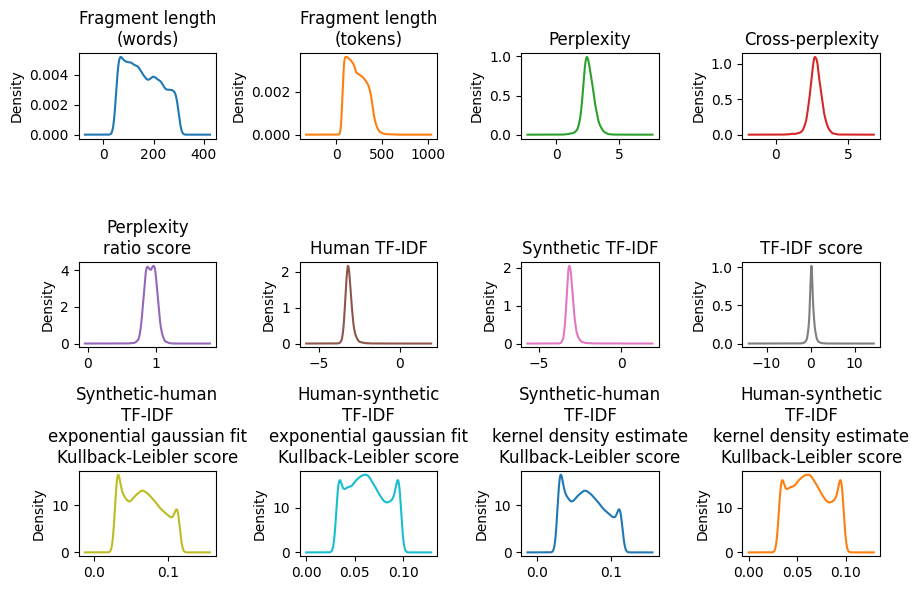

In [6]:
plot_funcs.plot_feature_distributions(features_train_df).show()

Have 12 features for plot:
 0: Fragment length (words)
 1: Fragment length (tokens)
 2: Perplexity
 3: Cross-perplexity
 4: Perplexity ratio score
 5: Human TF-IDF
 6: Synthetic TF-IDF
 7: TF-IDF score
 8: Synthetic-human TF-IDF exponential gaussian fit Kullback-Leibler score
 9: Human-synthetic TF-IDF exponential gaussian fit Kullback-Leibler score
 10: Synthetic-human TF-IDF kernel density estimate Kullback-Leibler score
 11: Human-synthetic TF-IDF kernel density estimate Kullback-Leibler score


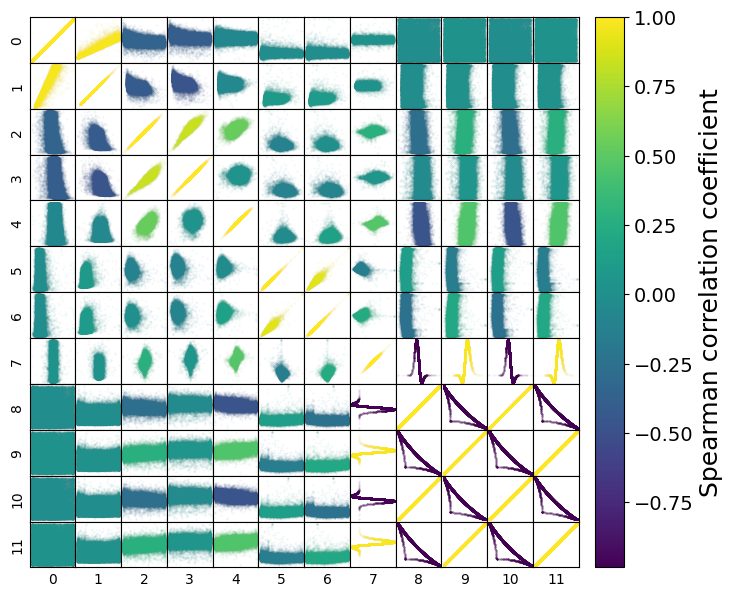

In [7]:
plot_funcs.plot_scatter_matrix(features_train_df).show()

## 3. Off-the-shelf classifiers

In [8]:
# Make evaluation metrics scorers
scoring = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

In [9]:
# Some parameters
kfolds = 3

### 2.1. XGBoost XGBClassifier

In [10]:
%%time 

# Run cross-validation
scores = cross_validate(
    XGBClassifier(),
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = -1,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'XGBC')

CPU times: user 87.1 ms, sys: 285 ms, total: 372 ms
Wall time: 3.33 s


### 2.2. scikit-learn GradientBoostingClassifier

In [11]:
%%time

# Run cross-validation
scores = cross_validate(
    GradientBoostingClassifier(),
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = -1,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'GBC')

CPU times: user 32.3 ms, sys: 11 ms, total: 43.3 ms
Wall time: 12.1 s


### 2.3. scikit-learn HistGradientBoostingClassifier

In [12]:
%%time

# Run cross-validation
scores = cross_validate(
    HistGradientBoostingClassifier(),
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = -1,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'HGBC')

CPU times: user 21.9 ms, sys: 3.33 ms, total: 25.2 ms
Wall time: 2.99 s


### 2.4. Results

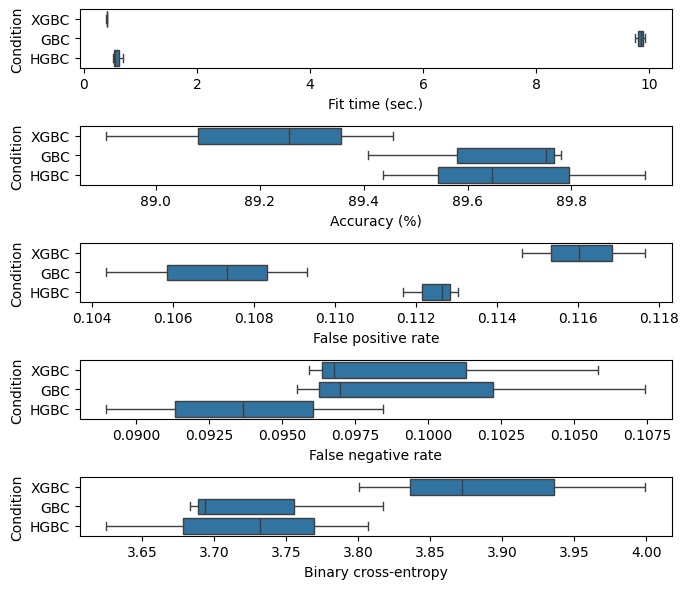

In [13]:
plot_funcs.plot_cross_validation(plots, results).show()

OK, pretty good - we are not over-fitting or just guessing the major class, we are in the mid-low 90% accuracy for all three implementation. This is actually a pretty good bump over the LLaMA2 based perplexity ratio score where we never got better than 88%. Problem now is as before, high false positive rate ~8% for all three implementations. We may be able to mitigate that somewhat at the cost of false negatives with some threshold tuning later. First let's do some:

## 3. Hyperparameter optimization

In [14]:
# How many iterations to run
validation_fraction = 0.3
hyperparameter_samples = 10
early_stopping_steps = 10
early_stopping_validation_fraction = 0.1

# Parameter optimization space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
    'max_iter': scope.int(hp.quniform('max_iter', 10, 1000, 1)),
    'max_leaf_nodes': scope.int(hp.quniform('max_leaf_nodes', 15, 60, 1)),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 1000, 1)),
    'min_samples_leaf': scope.int(hp.quniform('min_samples_leaf', 1, 100, 1)),
    'l2_regularization': hp.uniform('l2_regularization', 0.001, 1.0)
}

### 3.1. HistGradientBoostingClassifier: single training-validation split

In [15]:
# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = validation_fraction
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters we are not going to optimize set
model = HistGradientBoostingClassifier(
    early_stopping = True,
    validation_fraction = early_stopping_validation_fraction,
    n_iter_no_change = early_stopping_steps
)

best = fmin(
    fn = partial(
        helper_funcs.hyperopt,
        model = model,
        features_training = optimization_features_training, 
        labels_training = optimization_labels_training,
        features_validation = optimization_features_validation, 
        labels_validation = optimization_labels_validation
    ),
    space = space,                       # Parameter: value dictionary
    algo = tpe.suggest,                  # Algorithm to select parameters
    max_evals = hyperparameter_samples,  # Maximum number of iterations
    trials = trials                      # Logging
)

100%|██████████| 10/10 [00:01<00:00,  5.62trial/s, best loss: 3.7800300414424592]


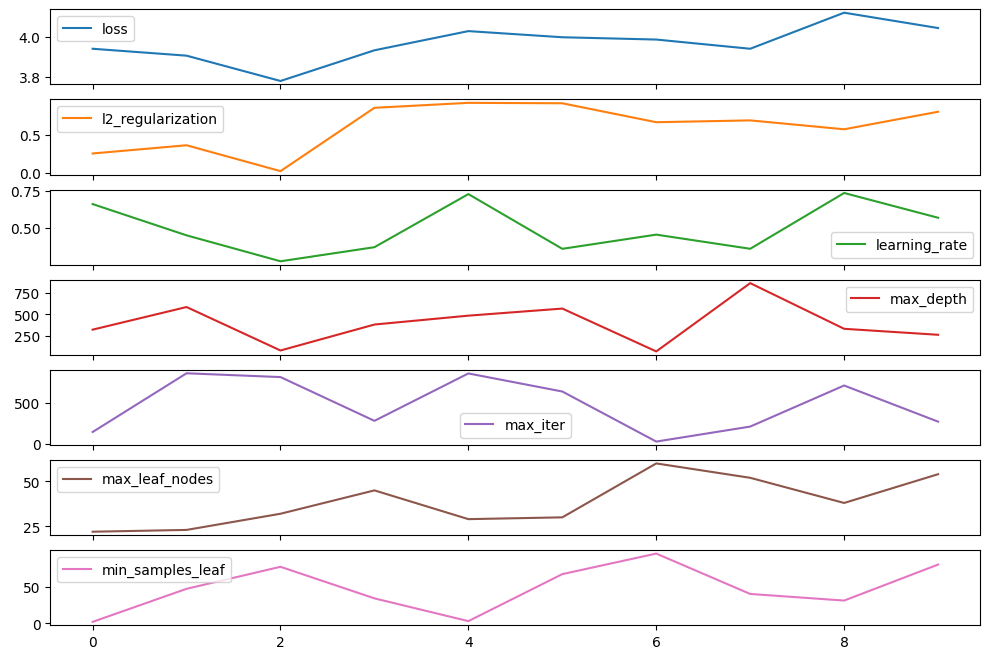

In [16]:
optimization_plot = plot_funcs.make_optimization_plot(trials.trials)

In [17]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
optimized_hgbc_model = HistGradientBoostingClassifier(
    learning_rate = best['learning_rate'],
    max_iter = int(best['max_iter']),
    max_leaf_nodes = int(best['max_leaf_nodes']),
    max_depth = int(best['max_depth']),
    min_samples_leaf = int(best['min_samples_leaf']),
    l2_regularization = best['l2_regularization'],
    early_stopping = True,
    validation_fraction = early_stopping_validation_fraction,
    n_iter_no_change = early_stopping_steps
)

# Run cross-validation
scores = cross_validate(
    optimized_hgbc_model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = -1,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized HGBC')


Optimized parameters:

 l2_regularization: 0.026211513731604314
 learning_rate: 0.27635933391779627
 max_depth: 76.0
 max_iter: 820.0
 max_leaf_nodes: 32.0
 min_samples_leaf: 77.0



### 3.2. HistGradientBoostingClassifier with k-fold cross validation

In [18]:
# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = HistGradientBoostingClassifier(
    early_stopping = True,
    validation_fraction = early_stopping_validation_fraction,
    n_iter_no_change = early_stopping_steps
)

# Set up trial logging
trials_cv = Trials()

best_cv = fmin(
    fn = partial(
       helper_funcs.hyperopt_cv,
       model = model,
       features = features_train, 
       labels = labels_train
    ),
    space = space,                       # Parameter: value dictionary
    algo = tpe.suggest,                  # Algorithm to select parameters
    max_evals = hyperparameter_samples,  # Maximum number of iterations
    trials = trials_cv                   # Logging
)

100%|██████████| 10/10 [00:14<00:00,  1.47s/trial, best loss: 3.8151897278273155]


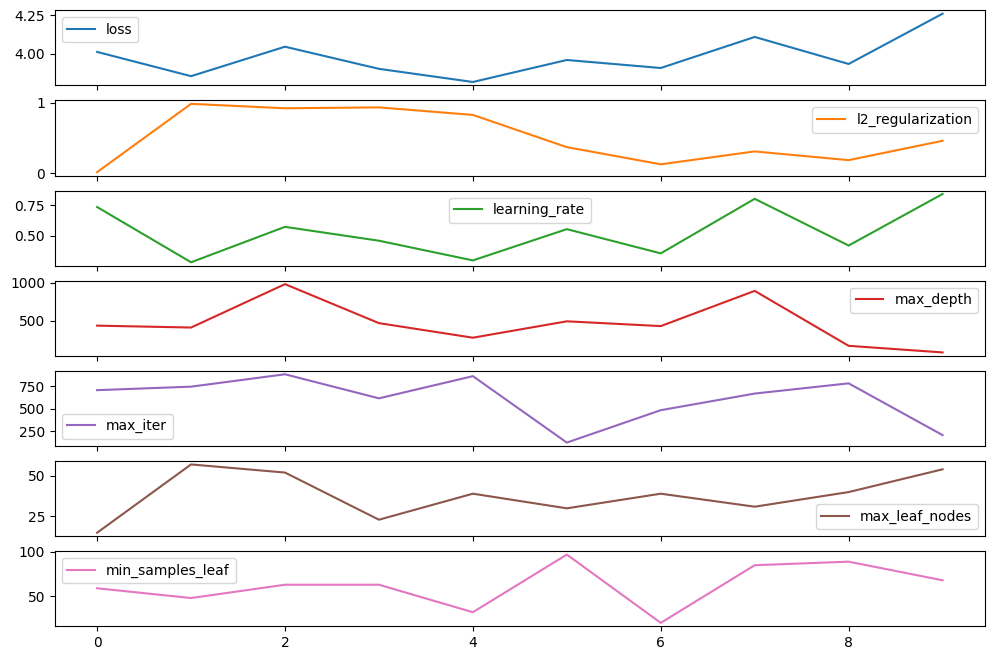

In [19]:
optimization_plot = plot_funcs.make_optimization_plot(trials_cv.trials)

In [20]:
print('Optimized parameters:\n')

for key, value in best_cv.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
cv_optimized_hgbc_model = HistGradientBoostingClassifier(
    learning_rate = best_cv['learning_rate'],
    max_iter = int(best_cv['max_iter']),
    max_leaf_nodes = int(best_cv['max_leaf_nodes']),
    max_depth = int(best_cv['max_depth']),
    min_samples_leaf = int(best_cv['min_samples_leaf']),
    l2_regularization = best_cv['l2_regularization'],
    early_stopping = True,
    validation_fraction = early_stopping_validation_fraction,
    n_iter_no_change = early_stopping_steps
)

# Run cross-validation
scores = cross_validate(
    cv_optimized_hgbc_model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = -1,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'CV Optimized HGBC')

Optimized parameters:

 l2_regularization: 0.8256977290960206
 learning_rate: 0.2991120278195808
 max_depth: 276.0
 max_iter: 863.0
 max_leaf_nodes: 39.0
 min_samples_leaf: 32.0



### 3.3. XGBClassifier: single training-validation split

In [21]:
# Parameter optimization space
space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 10.0),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 100, 1)),
    'min_child_weight': hp.uniform('min_child_weight', 0.0, 10.0),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'n_estimators': scope.int(hp.quniform('n_estimators', 1, 100, 1)),
    'num_parallel_tree': scope.int(hp.quniform('num_parallel_tree', 1, 10, 1))
}

# Make validation split of the training data
optimization_features_training, optimization_features_validation, optimization_labels_training, optimization_labels_validation = train_test_split(
    features_train,
    labels_train,
    test_size = validation_fraction
)

# Set up trial logging
trials = Trials()

# Instantiate a blank model with just the parameters
# we are not going to optimize set
model = XGBClassifier()

best = fmin(
    fn = partial(
       helper_funcs.hyperopt,
       model = model,
       features_training = optimization_features_training, 
       labels_training = optimization_labels_training,
       features_validation = optimization_features_validation, 
       labels_validation = optimization_labels_validation
    ),
    space = space,                       # Parameter: value dictionary
    algo = tpe.suggest,                  # Algorithm to select parameters
    max_evals = hyperparameter_samples,  # Maximum number of iterations
    trials = trials                      # Logging
)

100%|██████████| 10/10 [00:03<00:00,  2.68trial/s, best loss: 3.7076302725035406]


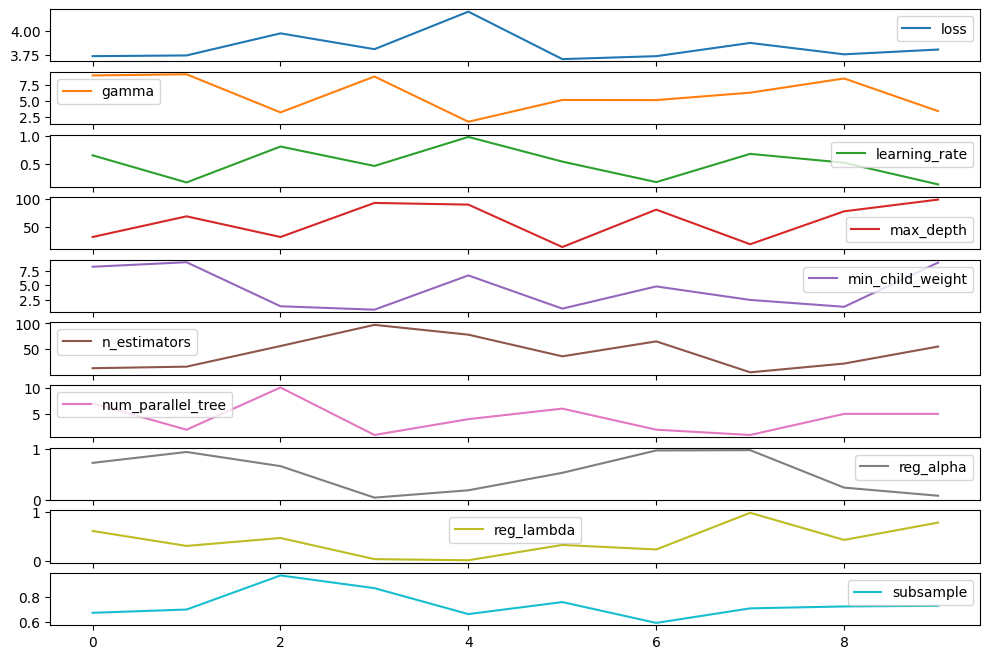

In [22]:
optimization_plot = plot_funcs.make_optimization_plot(trials.trials)

In [23]:
print('Optimized parameters:\n')

for key, value in best.items():
    print(f' {key}: {value}')
    
print()

# Retrain the model with the winning parameters
optimized_xgbc_model = XGBClassifier(
    learning_rate = best['learning_rate'],
    gamma = best['gamma'],
    max_depth = int(best['max_depth']),
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    reg_alpha = best['reg_alpha'],
    reg_lambda = int(best['reg_lambda']),
    n_estimators = int(best['num_parallel_tree'])
)

# Run cross-validation
scores = cross_validate(
    optimized_xgbc_model,
    features_train,
    labels_train,
    cv = kfolds,
    n_jobs = -1,
    scoring = scoring
)

# Collect the results
results = helper_funcs.add_cv_scores(results, scores, 'Optimized XGBC')


Optimized parameters:

 gamma: 5.096111881351604
 learning_rate: 0.5457700952427686
 max_depth: 14.0
 min_child_weight: 0.9926266075910073
 n_estimators: 36.0
 num_parallel_tree: 6.0
 reg_alpha: 0.528050885119162
 reg_lambda: 0.32302947548192473
 subsample: 0.75889964048494



### 3.4. Results

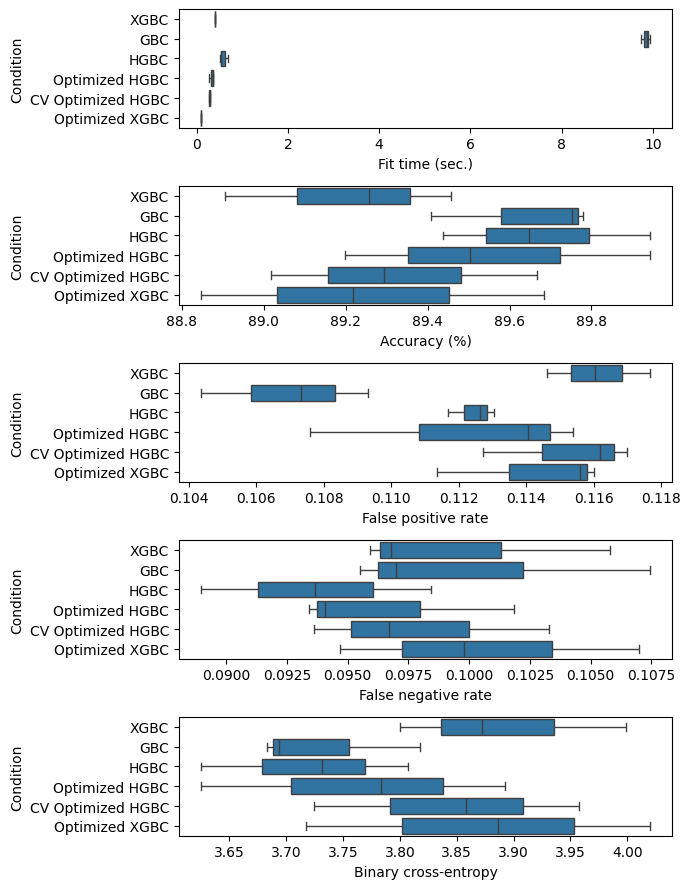

In [24]:
plot_funcs.plot_cross_validation(plots, results).show()

Looks like the cross validation optimized *HistGradientBoostingClassifier* is the overall winner. Let's train it on all of the training data with the optimized hyperparameters and then evaluate it on the held-out test set.

In [25]:
# Retrain the model with the winning parameters
cv_optimized_hgbc_model.fit(features_train, labels_train)

# Make predictions for held-out test data
y_pred = cv_optimized_hgbc_model.predict(features_test)

# Evaluate predictions
accuracy = accuracy_score(labels_test, y_pred)
print('\nAccuracy: %.1f%%' % (accuracy * 100.0))


Accuracy: 89.6%


OK - exactly the result we expected from cross-validation. That's good - we are not over fitting. Let's take at look a the confusion matrix:


Confusion matrix:
[[5932  766]
 [ 644 6175]]


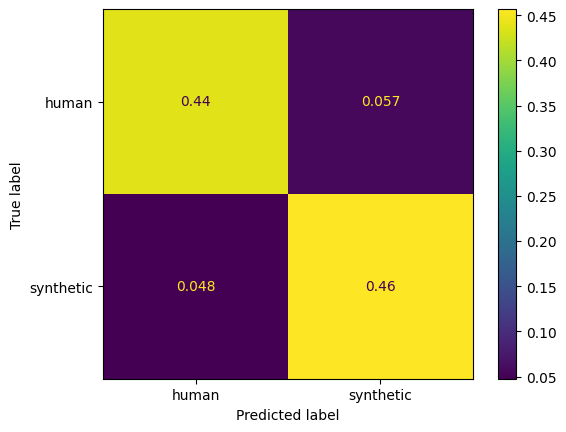

In [26]:
# Calculate confusion matrix
cm = confusion_matrix(labels_test, y_pred)
print('\nConfusion matrix:')
print(cm)

# # Normalize confusion matrix
# print(f'\nNormalized confusion matrix:')
# normalized_cm = cm / sum(sum(cm))

_ = ConfusionMatrixDisplay.from_estimator(
    cv_optimized_hgbc_model, 
    features_test, 
    labels_test, 
    normalize = 'all',
    display_labels = ['human', 'synthetic']
)